---
<center><h1>Cats/Dogs classification using a reduced training dataset </h1></center>

---

<p align="justify">
we’ll focus on the issue of cats/dogs classification using convolutional neural networks
(CNN) trained with very little data (common situation encountered in practical application).
As a practical example, we’ll focus on classifying images into categories: dogs or cats, using a dataset
with 4.000 pictures (2.000 for each class). The system will use 2.000 pictures for training, 1.000 for
validation and 1.000 for testing.


with data augmentation, transfer learning and a fine-tuning
</p>

In [ ]:
!pip install tensorflow

In [ ]:
import os
import shutil
from glob import glob
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import models
#from tensorflow.keras.optimizers import rmsprop_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from tensorflow.keras.applications import VGG16,ResNet50,InceptionV3,Xception,MobileNet
from tensorflow.keras.optimizers import RMSprop


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
base_directory = '/content/drive/MyDrive/Kaggle_Cats_And_Dogs_Dataset_Small'


train_cats_directory = str(base_directory+'/train/cat/')
validation_cats_directory = str(base_directory+'/validation/cat/')
test_cats_diretcory = str(base_directory+'/test/cat/')


train_dogs_directory = str(base_directory+'/train/dog/')
validation_dogs_directory = str(base_directory+'/validation/dog/')
test_dogs_diretcory = str(base_directory+'/test/dog/')

In [ ]:
#As a sanitary check verify how many pictures are in each directory
print('Total number of CATS used for training ={}'.format(len(os.listdir(train_cats_directory))))
print('Total number of CATS used for validation ={}'.format(len(os.listdir(validation_cats_directory))))
print('Total number of CATS used for testing ={}'.format(len(os.listdir(test_cats_diretcory))))

print('Total number of DOGS used for training ={}'.format(len(os.listdir(train_dogs_directory))))
print('Total number of DOGS used for validation ={}'.format(len(os.listdir(validation_dogs_directory))))
print('Total number of DOGS used for testing ={}'.format(len(os.listdir(test_dogs_diretcory))))

Total number of CATS used for training =1000
Total number of CATS used for validation =500
Total number of CATS used for testing =500
Total number of DOGS used for training =1000
Total number of DOGS used for validation =500
Total number of DOGS used for testing =500


###Image preprocessing

In [ ]:
import tensorflow as tf

def imagePreprocessing(base_directory,img_size=(150, 150)):

    #Creation of the image data generators for train and validation
    train_directory = base_directory + '/train'
    validation_directory = base_directory + '/validation'
    test_directory = base_directory + '/test'

    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_directory,target_size = (150, 150), batch_size = 20, class_mode='binary')
    validation_generator =validation_datagen.flow_from_directory(validation_directory,target_size = (150,150), batch_size = 20,shuffle=False, class_mode='binary')

    #Analyze the output of the train and validation generators
    for data_batch, labels_batch in train_generator:
        print('Data batch shape in train: ', data_batch.shape)
        print('Labels batch shape in train: ', labels_batch.shape)
        break
    for data_batch, labels_batch in validation_generator:
        print('Data batch shape in validation: ', data_batch.shape)
        print('Labels batch shape in validation: ', labels_batch.shape)
        break

    # Convert to tf.data.Dataset for performance boost
    train_dataset_gen = tf.data.Dataset.from_generator(
        lambda: train_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, img_size[0], img_size[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)

    validation_dataset_gen = tf.data.Dataset.from_generator(
        lambda: validation_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, img_size[0], img_size[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)

    return train_dataset_gen, validation_dataset_gen

In [ ]:
train_generator,validation_generator=imagePreprocessing(base_directory)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Data batch shape in train:  (20, 150, 150, 3)
Labels batch shape in train:  (20,)
Data batch shape in validation:  (20, 150, 150, 3)
Labels batch shape in validation:  (20,)


### CNN architecture
We will define our model in a function denoted *defineCNNModelFromScratch()*:


In [ ]:
def defineCNNModelFromScratch():
  #Initialize
  model = models.Sequential()

  #first hidden layer as a convolutional layer
  model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 3),activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Flatten())

  layers.Dropout(0.5)

  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(1, activation='sigmoid'))

  #Visualize the network arhitecture (list of layers)
  model.summary()


  #Compile the model
  model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = defineCNNModelFromScratch()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
 #train the model
 history = model.fit(train_generator, steps_per_epoch=100, epochs=10,validation_data=validation_generator, validation_steps=50)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 986s 10s/step - accuracy: 0.5178 - loss: 0.6917 - val_accuracy: 0.5010 - val_loss: 0.6842
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5468 - loss: 0.6806 - val_accuracy: 0.5930 - val_loss: 0.6598
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5920 - loss: 0.6606 - val_accuracy: 0.5850 - val_loss: 0.6574
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6268 - loss: 0.6453 - val_accuracy: 0.6370 - val_loss: 0.6283
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6526 - loss: 0.6125 - val_accuracy: 0.6120 - val_loss: 0.6494
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6983 - loss: 0.5806 - val_accuracy: 0.6590 - val_loss: 0.6020
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7049 - loss: 0.5542 - val_accuracy: 0.6700 - val_loss: 0.5999
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7258 - loss: 0.5345 - val_acc

### Graphs
<p align="justify">

Display the system performance – In this step we will plot the loss and accuracy function of the model over the training and validation data. The system performance will be defined within a function denoted *visualizeTheTrainingPerformance(history)* that takes as input the history (that contains the model accuracy and loss obtained on the test and training dataset at the end of each epoch).
</p>


In [ ]:
def visualizeTheTrainingPerformances(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  pyplot.title('Training and validation accuracy')
  pyplot.plot(epochs, acc, 'bo', label = 'Training accuracy')
  pyplot.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
  pyplot.legend()
  pyplot.figure()
  pyplot.title('Training and validation loss')
  pyplot.plot(epochs, loss, 'bo', label = 'Training loss')
  pyplot.plot(epochs, val_loss, 'b', label = 'Validation loss')
  pyplot.legend
  pyplot.savefig('accuracy_plot.png')
  pyplot.figure()
  pyplot.savefig('loss_plot.png')
  pyplot.show()
  return

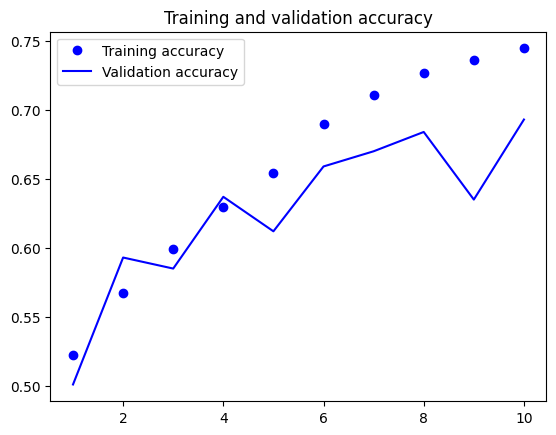

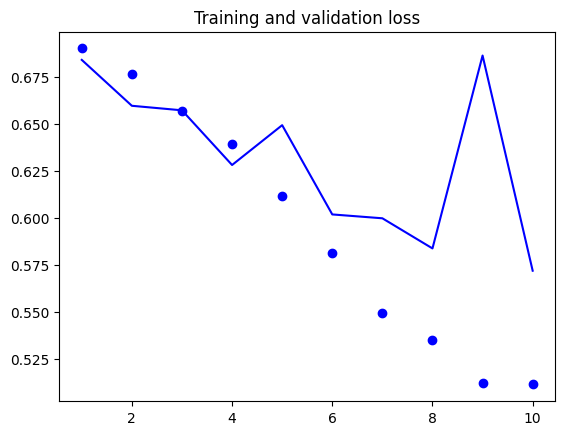

<Figure size 640x480 with 0 Axes>

In [ ]:
visualizeTheTrainingPerformances(history)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    base_directory + '/test',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)

# Évaluation
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 285s 6s/step - accuracy: 0.7531 - loss: 0.5596
Test Loss: 0.5697
Test Accuracy: 0.7100


In [ ]:
model.save('/content/Model_cats_dogs_small_dataset.h5')


In [ ]:
!mv /content/Model_cats_dogs_small_dataset.h5 /content/drive/MyDrive/


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Model_cats_dogs_small_dataset.h5')

import cv2
import numpy as np

def loadImages():
    image_paths = [
        '/content/drive/MyDrive/Kaggle_Cats_And_Dogs_Dataset_Small/test1.jpg',
        '/content/drive/MyDrive/Kaggle_Cats_And_Dogs_Dataset_Small/test2.jpg'
    ]

    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (150, 150))           # Resize to match training
        img = img.astype('float32') / 255.0         # Normalize
        images.append(img)

    return np.array(images)

In [ ]:
images = loadImages()
predictions = model.predict(images)

for i, p in enumerate(predictions):
    label = "Dog" if p > 0.5 else "Cat"
    print(f"Image test{i+1}.jpg: {label} ({p[0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Image test1.jpg: Dog (0.5191)
Image test2.jpg: Dog (0.9432)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def imagePreprocessingAugmented(base_directory, img_size=(150, 150)):
    train_directory = base_directory + '/train'
    validation_directory = base_directory + '/validation'

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=img_size,
        batch_size=20,
        class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_directory,
        target_size=img_size,
        batch_size=20,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, validation_generator


In [ ]:
train_gen_aug, val_gen_aug = imagePreprocessingAugmented(base_directory)
tf.config.run_functions_eagerly(True)

model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen_aug,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_gen_aug,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.6446 - loss: 0.6162 - val_accuracy: 0.6560 - val_loss: 0.6120
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6843 - loss: 0.5952 - val_accuracy: 0.6670 - val_loss: 0.6065
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.6821 - loss: 0.5898 - val_accuracy: 0.6970 - val_loss: 0.5593
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6872 - loss: 0.5771 - val_accuracy: 0.6950 - val_loss: 0.5632
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.7062 - loss: 0.5672 - val_accuracy: 0.6990 - val_loss: 0.5565
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.7144 - loss: 0.5763 - val_accuracy: 0.7100 - val_loss: 0.5474
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.7221 - loss: 0.5409 - val_accuracy: 0.7170 - val_loss: 0.5447
Epoch 8/10
10

In [ ]:
def visualizeTheTrainingPerformances_augmented(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  pyplot.title('Training and validation accuracy')
  pyplot.plot(epochs, acc, 'bo', label = 'Training accuracy')
  pyplot.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
  pyplot.legend()
  pyplot.figure()
  pyplot.title('Training and validation loss')
  pyplot.plot(epochs, loss, 'bo', label = 'Training loss')
  pyplot.plot(epochs, val_loss, 'b', label = 'Validation loss')
  pyplot.legend
  pyplot.savefig('augmented_accuracy.png')
  pyplot.figure()
  pyplot.savefig('augmented_loss.png')
  pyplot.show()
  return

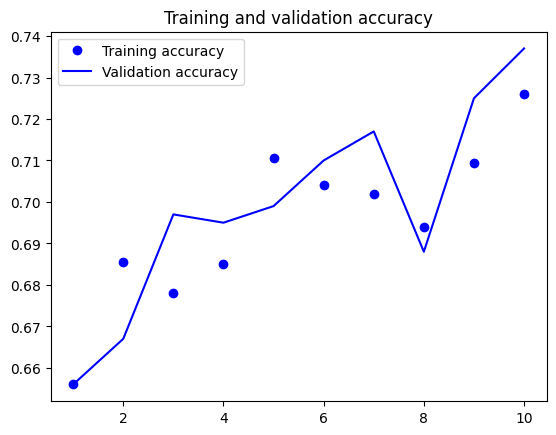

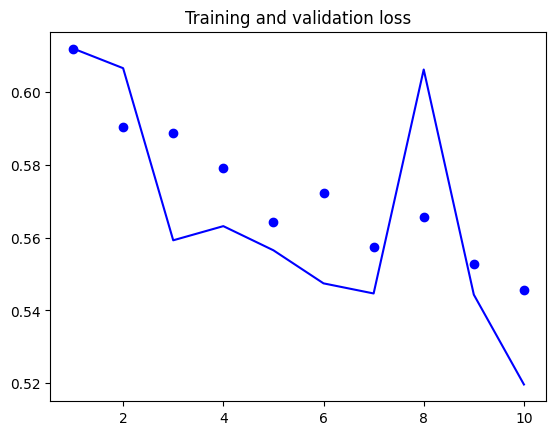

<Figure size 640x480 with 0 Axes>

In [ ]:
visualizeTheTrainingPerformances_augmented(history)

Sans data augmentation, le modèle apprend vite mais overfit : la précision sur l'entraînement est bien supérieure à celle sur la validation.
Avec augmentation + dropout, l'apprentissage est plus lent, mais la précision sur la validation est plus stable, ce qui traduit une meilleure généralisation.

In [ ]:
def defineCNNModelVGGPretrained():
  #Load the pretrained VGG16 network in a variable called baseModel
  #The top layers will be omitted; The input_shape will be kept to (150, 150, 3)
  baseModel = VGG16(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

  #Visualize the network arhitecture (list of layers)
  print("Trainable parameters:", baseModel.count_params())


  #Freeze the baseModel convolutional layers in order not to allow training
  for layer in baseModel.layers:
      layer.trainable = False

  baseModel.summary()

  #Create the final model and add the layers from the baseModel
  pretrained_model = models.Sequential()
  pretrained_model.add(baseModel)


  pretrained_model.add(layers.Flatten())


  pretrained_model.add(layers.Dropout(0.5))


  pretrained_model.add(layers.Dense(512, activation='relu'))


  pretrained_model.add(layers.Dense(1, activation='sigmoid'))


  pretrained_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


  return pretrained_model

In [ ]:
def defineCNNModelVGGFineTuning():
    baseModel = VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

    set_trainable = False
    for layer in baseModel.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        layer.trainable = set_trainable

    print("\nTrainable layers:")
    for layer in baseModel.layers:
        print(f"{layer.name}: {'Yes' if layer.trainable else 'No'}")

    model = models.Sequential()
    model.add(baseModel)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=RMSprop(learning_rate=1e-5),  # Learning rate plus bas
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


# Comparison between different models



In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16, Xception, InceptionV3, ResNet50, MobileNet

def defineTransferModel(architecture='VGG16', input_shape=(150, 150, 3)):
    architectures = {
        'VGG16': VGG16,
        'Xception': Xception,
        'Inception': InceptionV3,
        'ResNet50': ResNet50,
        'MobileNet': MobileNet
    }

    if architecture not in architectures:
        raise ValueError(f"Architecture {architecture} not supported.")

    base_model = architectures[architecture](weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False  # freeze all layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=RMSprop(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
for arch in ['VGG16', 'Xception', 'Inception', 'ResNet50', 'MobileNet']:
    print(f"\nTraining model with architecture: {arch}")
    model = defineTransferModel(arch)
    history = model.fit(train_generator, epochs=10, validation_data=validation_generator)
    val_acc = history.history['val_accuracy'][-1]
    print(f"Validation accuracy for {arch}: {val_acc:.4f}")


Training model with architecture: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
    183/Unknown 3570s 20s/step - accuracy: 0.5786 - loss: 0.6720